# Bone Break Classification

The goal of this project is to develop a Convolutional Neural Network model to automate the classification of bone fractures from X-ray images. By training a deep learning model on a diverse set of fracture types, we aim to create a system capable of providing accurate and timely insights to medical professionals, thereby enhancing patient care. This model will assist in identifying various types of fractures, such as:

- Avulsion fractures
- Comminuted fractures
- Fracture-dislocations
- Greenstick fractures
- Hairline fractures
- Impacted fractures
- Longitudinal fractures
- Oblique fractures
- Pathological fractures
- Spiral fractures

By leveraging CNNs implemented in PyTorch, the project aims to streamline the fracture diagnosis process, offering valuable data-driven support for better decision-making.

The dataset used for training the model can be accessed [here](https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data).

In [1]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils, models
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.rcParams.update({'axes.grid': False})

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [3]:
DATA_DIR = "data"
IMAGE_SIZE = 256
BATCH_SIZE = 64

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=data_transforms)

train_size = int(0.7 * len(full_dataset)) 
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = data.random_split(
    full_dataset, 
    [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

valid_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

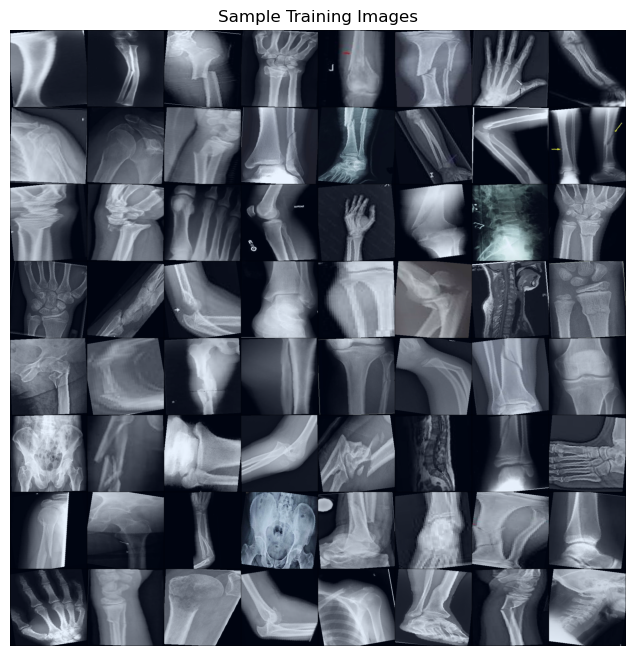

In [5]:
# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [6]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=20, verbose=True):
    train_loss, valid_loss, valid_accuracy = [], [], []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0

        # Training
        model.train()
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item() * X.size(0)
        train_loss.append(train_batch_loss / len(trainloader.dataset))

        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item() * X.size(0)
                _, predicted = torch.max(y_hat, 1)
                valid_batch_acc += (predicted == y).sum().item()
        
        valid_loss.append(valid_batch_loss / len(validloader.dataset))
        valid_accuracy.append(valid_batch_acc / len(validloader.dataset))
        
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.4f} |",
                  f"Valid Loss: {valid_loss[-1]:.4f} |",
                  f"Valid Accuracy: {valid_accuracy[-1]:.4f}")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

def test(model, criterion, test_loader):
    test_loss = 0
    test_accuracy = 0

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item() * X.size(0)
            _, predicted = torch.max(y_hat, 1)
            test_accuracy += (predicted == y).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    return {"test_loss": test_loss, "test_accuracy": test_accuracy}

In [7]:
class CNN_bone_break(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(16 * 16 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        return self.main(x)

In [9]:
model = CNN_bone_break().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

results = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=20)

Epoch 1: Train Loss: 2.3813 | Valid Loss: 2.2665 | Valid Accuracy: 0.1479
Epoch 2: Train Loss: 2.2511 | Valid Loss: 2.2824 | Valid Accuracy: 0.1065
Epoch 3: Train Loss: 2.2155 | Valid Loss: 2.2792 | Valid Accuracy: 0.1657
Epoch 4: Train Loss: 2.1864 | Valid Loss: 2.2539 | Valid Accuracy: 0.1716
Epoch 5: Train Loss: 2.1448 | Valid Loss: 2.2375 | Valid Accuracy: 0.1598
Epoch 6: Train Loss: 2.1195 | Valid Loss: 2.3134 | Valid Accuracy: 0.1183
Epoch 7: Train Loss: 2.1027 | Valid Loss: 2.1814 | Valid Accuracy: 0.2071
Epoch 8: Train Loss: 2.0347 | Valid Loss: 2.2030 | Valid Accuracy: 0.1893
Epoch 9: Train Loss: 1.9821 | Valid Loss: 2.3374 | Valid Accuracy: 0.1953
Epoch 10: Train Loss: 1.9304 | Valid Loss: 2.2398 | Valid Accuracy: 0.2604
Epoch 11: Train Loss: 1.8374 | Valid Loss: 2.2785 | Valid Accuracy: 0.2189
Epoch 12: Train Loss: 1.7515 | Valid Loss: 2.1750 | Valid Accuracy: 0.2663
Epoch 13: Train Loss: 1.6898 | Valid Loss: 2.2747 | Valid Accuracy: 0.2426
Epoch 14: Train Loss: 1.5579 | Val

In [11]:
# Test the model
test_results = test(model, criterion, test_loader)

Test Loss: 2.6150 | Test Accuracy: 0.3176


In [20]:
class BoneResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = False
        in_features = self.resnet.fc.in_features

        self.resnet.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

        
        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.resnet(x)

In [21]:
bone_res = BoneResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bone_res.parameters(), lr=1e-4)
results = trainer(bone_res, criterion, optimizer, train_loader, valid_loader, epochs=50)

Epoch 1: Train Loss: 6.6847 | Valid Loss: 5.5280 | Valid Accuracy: 0.0355
Epoch 2: Train Loss: 5.4154 | Valid Loss: 3.8778 | Valid Accuracy: 0.1183
Epoch 3: Train Loss: 3.9830 | Valid Loss: 3.1898 | Valid Accuracy: 0.1361
Epoch 4: Train Loss: 2.9286 | Valid Loss: 2.8604 | Valid Accuracy: 0.1598
Epoch 5: Train Loss: 2.1736 | Valid Loss: 2.5094 | Valid Accuracy: 0.2012
Epoch 6: Train Loss: 1.7710 | Valid Loss: 2.3113 | Valid Accuracy: 0.2840
Epoch 7: Train Loss: 1.5011 | Valid Loss: 2.2296 | Valid Accuracy: 0.2367
Epoch 8: Train Loss: 1.2966 | Valid Loss: 2.1004 | Valid Accuracy: 0.3254
Epoch 9: Train Loss: 1.0952 | Valid Loss: 2.0505 | Valid Accuracy: 0.3373
Epoch 10: Train Loss: 0.9513 | Valid Loss: 2.1537 | Valid Accuracy: 0.3195
Epoch 11: Train Loss: 0.8448 | Valid Loss: 2.0687 | Valid Accuracy: 0.3846
Epoch 12: Train Loss: 0.7643 | Valid Loss: 2.1894 | Valid Accuracy: 0.3550
Epoch 13: Train Loss: 0.5403 | Valid Loss: 2.0930 | Valid Accuracy: 0.3846
Epoch 14: Train Loss: 0.5198 | Val

In [22]:
test_results = test(bone_res, criterion, test_loader)

Test Loss: 2.5261 | Test Accuracy: 0.4471
